In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, transform_bounding_box_to_sensor_coord_and_get_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,transform_box_from_world_to_sensor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion
from lyft_dataset_sdk.utils.geometry_utils import points_in_box

In [4]:

train_df = parse_train_csv()
sample_token, bounding_box = get_train_data_sample_token_and_box(0, train_df)

first_train_sample = level5data.get('sample', sample_token)

lidar_data_token = first_train_sample['data']['LIDAR_TOP']

mask, lpc_array_in_cam_coord, filtered_pc_2d, _, image = get_pc_in_image_fov(lidar_data_token, 'CAM_FRONT', bounding_box)



100%|██████████| 22680/22680 [00:03<00:00, 7028.80it/s] 


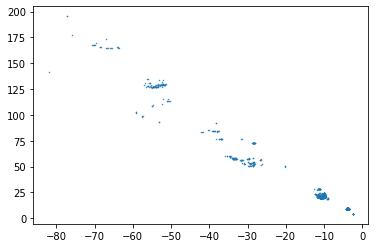

In [5]:
plt.scatter(lpc_array_in_cam_coord[0,:],lpc_array_in_cam_coord[2,:],s=0.2)

In [6]:
camera_token = extract_other_sensor_token('CAM_FRONT', lidar_data_token)
bounding_box_sensor_coord = transform_box_from_world_to_sensor_coordinates(bounding_box, camera_token)

In [7]:
box_corners_array=bounding_box_sensor_coord.corners()
box_corners_array.shape

(3, 8)

### Plot the bird view in camera coordinates (xz axis)

Text(0, 0.5, 'z-axis')

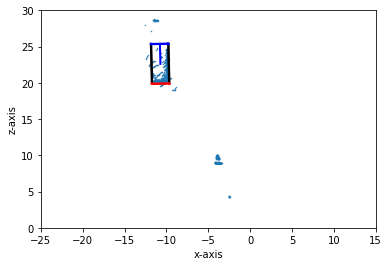

In [8]:
fig,ax=plt.subplots(ncols=1,nrows=1)
projection_mtx=np.array([[1,0,0],[0,0,1],[0,0,0]])
bounding_box_sensor_coord.render(axis=ax,view=projection_mtx)
ax.scatter(lpc_array_in_cam_coord[0,:],lpc_array_in_cam_coord[2,:],s=0.2)
ax.set_xlim([-25,15])
ax.set_ylim([0,30])
ax.set_xlabel("x-axis")
ax.set_ylabel("z-axis")

### Plot the bird view in camera coordinates (zx axis)

Text(0, 0.5, 'x-axis')

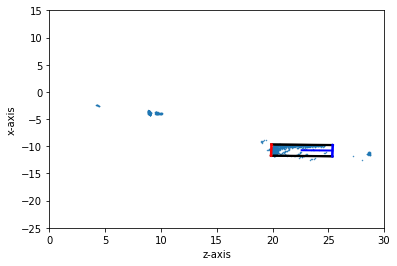

In [25]:
fig,ax=plt.subplots(ncols=1,nrows=1)
projection_mtx=np.array([[0,0,1],[1,0,0],[0,0,0]])
bounding_box_sensor_coord.render(axis=ax,view=projection_mtx)
ax.scatter(lpc_array_in_cam_coord[2,:],lpc_array_in_cam_coord[0,:],s=0.2)
ax.set_ylim([-25,15])
ax.set_xlim([0,30])
ax.set_xlabel("z-axis")
ax.set_ylabel("x-axis")

In [10]:
box_corners=bounding_box_sensor_coord.corners()
v=box_corners[:,0]-box_corners[:,4]

In [11]:
np.arctan2(-v[2],v[0])*180/np.pi

-91.13259667466177

In [12]:
box_corners.shape

(3, 8)

## Check points in box

In [13]:
type(lpc_array_in_cam_coord)

numpy.ndarray

In [14]:
points_in_box(bounding_box_sensor_coord,lpc_array_in_cam_coord[0:3,:])

array([False, False, False, ..., False, False, False])

### Another way of doing this (code from Frustum pointnets)

def in_hull(p, hull):
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0


def extract_pc_in_box3d(pc, box3d):
    ''' pc: (N,3), box3d: (8,3) '''
    box3d_roi_inds = in_hull(pc[:, 0:3], box3d)
    return pc[box3d_roi_inds, :], box3d_roi_inds

In [15]:
def in_hull(p, hull):
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0


def extract_pc_in_box3d(input_pc, input_box3d):
    """
    The code and in_hull functions are copied from frustum-point on
    https://github.com/charlesq34/frustum-pointnets

    :param pc: 3XN array
    :param box3d: 3x8 array
    :return:
    """

    assert input_box3d.shape == (3, 8)
    assert input_pc.shape[0] == 3
    pc = np.transpose(input_pc)
    box3d = np.transpose(input_box3d)

    box3d_roi_inds = in_hull(pc[:, 0:3], box3d)
    return pc[box3d_roi_inds, :], box3d_roi_inds

In [16]:
bounding_box_sensor_coord.corners().T.shape

(8, 3)

In [17]:
lpc_array_in_cam_coord[0:3,:].T.shape

(1353, 3)

In [18]:
pcs,inds=extract_pc_in_box3d(lpc_array_in_cam_coord[0:3,:],bounding_box_sensor_coord.corners())

In [19]:
pcs.shape

(739, 3)

In [20]:
inds

array([False, False, False, ..., False, False, False])

In [21]:
np.sum(inds)

739

In [22]:
def plot_cam_top_view(lpc_array_in_cam_coord,bounding_box_sensor_coord):
    fig,ax=plt.subplots(ncols=1,nrows=1)
    projection_mtx=np.array([[1,0,0],[0,0,1],[0,0,0]])
    bounding_box_sensor_coord.render(axis=ax,view=projection_mtx)
    ax.scatter(lpc_array_in_cam_coord[0,inds],lpc_array_in_cam_coord[2,inds])
    ax.set_xlim([-25,15])
    ax.set_ylim([0,30])

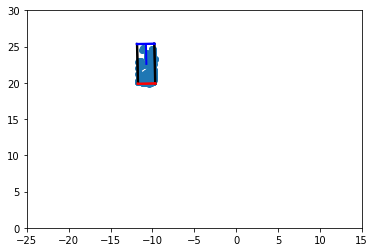

In [23]:
plot_cam_top_view(lpc_array_in_cam_coord,bounding_box_sensor_coord)

(3, 1353)


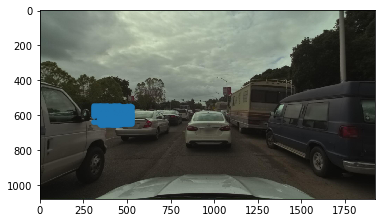

In [24]:
fig, ax = plt.subplots(1, 1)
ax.imshow(image)
print(filtered_pc_2d.shape)
ax.plot(filtered_pc_2d[0, :], filtered_pc_2d[1, :], '.')
plt.show()